In this notebook, we investigate the image reconstruction under Poisson noise.  
The candidates are:  
1. Raster scan;
2. Basis scan;
3. Compressed sensing;
4. Hyper resolution;
5. Voxtel camera;

In [1]:
class Scan_Strategy:
    def __init__(self):
        self.prop = {};
    def Adding_prop(self, name: str, item):
        self.prop[name] = item;
    def Removing_prop(self, name:str):
        del self.prop[name];

def remove_dir(dir):
    dir = dir.replace('\\', '/')
    if(os.path.isdir(dir)):
        for p in os.listdir(dir):
            remove_dir(os.path.join(dir,p))
        if(os.path.exists(dir)):
            os.rmdir(dir)
    else:
        if(os.path.exists(dir)):
            os.remove(dir)

In [2]:
import os;
from google.colab import drive
drive.mount('/content/drive', force_remount=True);

path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation";
os.chdir(path);
os.listdir(path);

Mounted at /content/drive


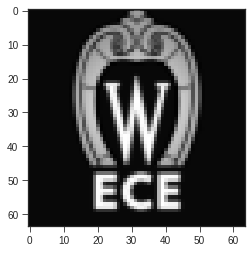

In [3]:
import numpy as np;
import matplotlib.pyplot as plt;
plt.style.use('seaborn-ticks')

#plt.style.use('classic');
#plt.rcParams['figure.figsize'] = [4,3];

import matplotlib.image as mpimg;

from PMT_compressed_sensing_simu import Compressed_sensing_PMT as CSP;
from YZ_masks import Haar_2d, Hyper_raster;

r = 64;
c = 64;



error = [];

pmt = CSP();
pmt.Load_img("ECE.jpg",RGB = False, size = (r,c), anti_aliasing = False);  

In [4]:
os.getcwd()

'/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation'

In [5]:
#########################################################
ratio_val = 0. ## to determine how many 1s in the masks!
Pnoise = True;
Gnoise = False;

Voxtel_camera = 25 * 256**2; ## the photon number per second for Vextel camera is 400
#########################################################


n_ph_per_sec = 1e6;

compress_rate = 0.3;

#maximum_time = 1e15;
maximum_time = 100;

#--------------------------------------------
ratio_val = 0.4;
mode = "BMC"
#--------------------------------------------

data_density = 10;
time = (np.arange(data_density)+1)/data_density*np.log10(maximum_time);
time = [-2, -1,-0] + list(time);
time = np.power(10, time);

'''
Error_RS = np.zeros(len(time));
Error_BS = np.zeros(len(time));
Error_CS = np.zeros(len(time));
Error_hr = np.zeros(len(time));
Error_veoxtel = np.zeros(len(time));
'''

'\nError_RS = np.zeros(len(time));\nError_BS = np.zeros(len(time));\nError_CS = np.zeros(len(time));\nError_hr = np.zeros(len(time));\nError_veoxtel = np.zeros(len(time));\n'

In [6]:
## initialize the DMD masks for the four measure strategy!
_,_,layers = pmt.img_tensor.shape;

RS = Scan_Strategy();
RS.Adding_prop("cycles", r*c);
pmt.Make_DMD_basis(RS.prop["cycles"], scan_mode='Raster');
RS.Adding_prop("phi", pmt.DMD_basis);
RS.Adding_prop("n_photon", 1e6);
RS.Adding_prop("measure", np.zeros((RS.prop["cycles"], layers, len(time))));
RS.Adding_prop("error", np.zeros(len(time)));





BS = Scan_Strategy();
BS.Adding_prop("cycles", r*c);
pmt.Make_DMD_basis(BS.prop["cycles"], scan_mode='Basis', ratio = ratio_val);
BS.Adding_prop("phi", pmt.DMD_basis);
BS.Adding_prop("n_photon", 1e6);
BS.Adding_prop("measure", np.zeros((BS.prop["cycles"], layers, len(time))));
BS.Adding_prop("error", np.zeros(len(time)));

BS_CS = Scan_Strategy(); ## use CS to recons BS
BS_CS .Adding_prop("cycles", r*c);
pmt.Make_DMD_basis(BS_CS.prop["cycles"], scan_mode='Basis', ratio = ratio_val);
BS_CS .Adding_prop("phi", pmt.DMD_basis);
BS_CS .Adding_prop("n_photon", 1e6);
BS_CS .Adding_prop("measure", np.zeros((BS.prop["cycles"], layers, len(time))));
BS_CS .Adding_prop("error", np.zeros(len(time)));

HR = Scan_Strategy();
HR.Adding_prop("cycles", int(compress_rate * r*c));
pmt.Make_DMD_basis(HR.prop["cycles"], scan_mode='Basis',ratio = ratio_val);
HR.Adding_prop("phi", pmt.DMD_basis);
HR.Adding_prop("n_photon", 1e6);
HR.Adding_prop("measure", np.zeros((HR.prop["cycles"], layers, len(time))));
HR.Adding_prop("error", np.zeros(len(time)));


CS = Scan_Strategy();
CS.Adding_prop("cycles", int(compress_rate * r*c));

threshold = 1 - np.mean(HR.prop["phi"]);
random_mask = np.ceil(np.random.rand(CS.prop["cycles"], r*c) - threshold);

CS.Adding_prop("phi", random_mask);
CS.Adding_prop("n_photon", 1e6);
CS.Adding_prop("measure", np.zeros((CS.prop["cycles"], layers, len(time))));
CS.Adding_prop("error", np.zeros(len(time)));

Voxtel = Scan_Strategy();
Voxtel.Adding_prop("phi", RS.prop["phi"]);## same as Raster scan
Voxtel.Adding_prop("n_photon", 25*256**2);
Voxtel.Adding_prop("cycles", r*c);
Voxtel.Adding_prop("measure", np.zeros((Voxtel.prop["cycles"], layers, len(time))));
Voxtel.Adding_prop("error", np.zeros(len(time)));

print("BS mask mean: %.3e"%np.mean(BS.prop['phi']))
print("HR mask mean: %.3e"%np.mean(HR.prop['phi']))
print("CS mask mean: %.3e"%np.mean(CS.prop['phi']))

BS mask mean: 2.432e-01
HR mask mean: 2.502e-01
CS mask mean: 2.501e-01


In [7]:
path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation/Before and After mask constant";
os.chdir(path);

dir_name = "save simulation result";

if os.path.exists("save simulation result") == False:
    os.mkdir("save simulation result");


os.chdir(dir_name);

dir_name = mode;

if os.path.exists(dir_name) == False:
    os.mkdir(dir_name);


os.chdir(dir_name);


dir_name = "ratio_value %.2e"%ratio_val;

if os.path.exists(dir_name) == False:
    os.mkdir(dir_name);
os.chdir(dir_name);

|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!0 / 13


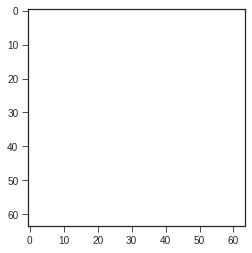

1 / 13


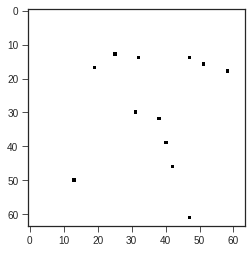

2 / 13


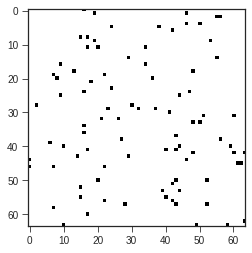

3 / 13


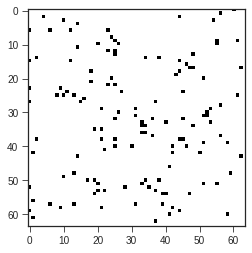

4 / 13


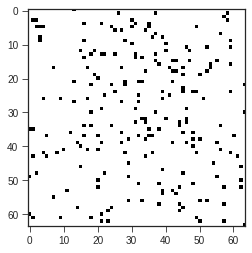

5 / 13


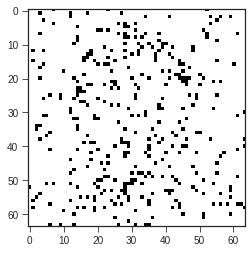

6 / 13


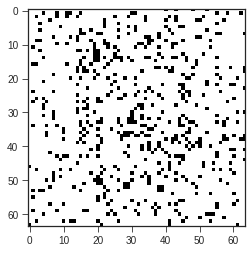

7 / 13


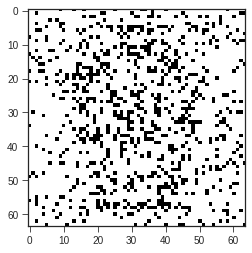

8 / 13


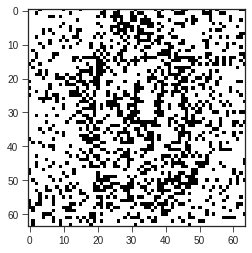

9 / 13


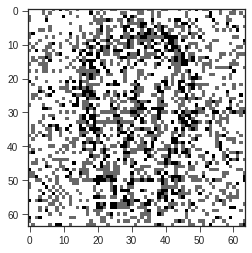

10 / 13


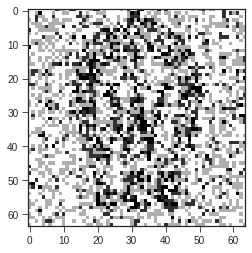

11 / 13


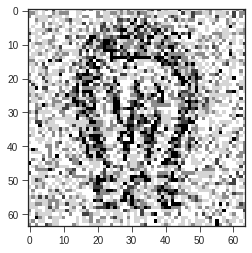

12 / 13


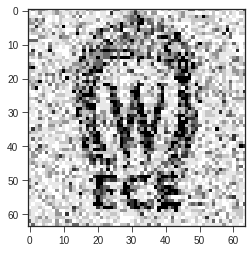

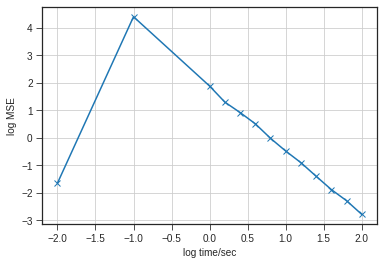

In [8]:
dir_name = "RS";

path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation/Before and After mask constant/save simulation result";
path += ('/' + mode);
path += "/ratio_value %.2e"%ratio_val;

os.chdir(path);

if os.path.exists(dir_name) == True:
    remove_dir(dir_name);

os.mkdir(dir_name);

os.chdir('/'.join([path, dir_name]));


light_level = [];

### Raster scan
Obj = RS;
measure = Obj.prop["measure"];
photon_per_sec = Obj.prop["n_photon"];
cycles = Obj.prop["cycles"];
basis = Obj.prop["phi"];

inv_basis = basis;
Error = Obj.prop["error"];

factor = cycles * (r*c);

for time_index in range(len(time)):
    pmt.YZ_process_bar((time_index+1)/len(time), theme = False);
    time_ep = time[time_index];

    n_ph_tot = time_ep * photon_per_sec;    
    light_level += [n_ph_tot / factor];
    measure[:,:,time_index] = pmt.PMT_measure_simu(light_level[-1], cycles,
                                                   Poisson = Pnoise, Gaussian = Gnoise,
                                                   upload_DMD_basis = basis);

#RS.prop["measure"] = measure;
################################################################################
#measure = RS.prop["measure"];


for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_direct_inverse_reconstruction(r, c, inv_basis, measure[:,:,time_index], CS = False);
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);

    recons_clipped = pmt.img_reconstructed;
    
    this_error = (np.mean((recons_clipped - pmt.img)**2));    
    
    Error[time_index] = this_error;

    condition = "%s. mode: %s_time: %.2e light_level: %.2e"%(time_index,mode, time[time_index], light_level[time_index])
    mpimg.imsave( condition +'.png', pmt.img_reconstructed, cmap = 'gray')
    
plt.figure();
plt.plot(np.log10(time), np.log(Error), marker = 'x');
plt.xlabel("log time/sec");
plt.ylabel("log MSE");
plt.grid();
plt.savefig("Error.jpg");
plt.show();

|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!0 / 13


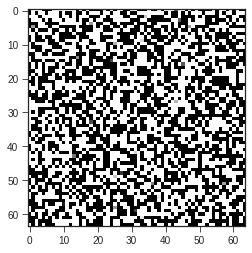

1 / 13


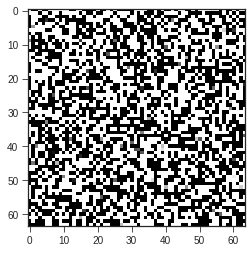

2 / 13


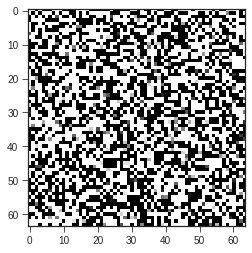

3 / 13


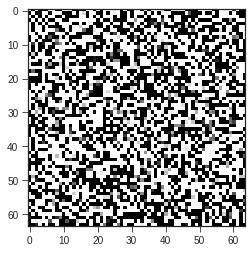

4 / 13


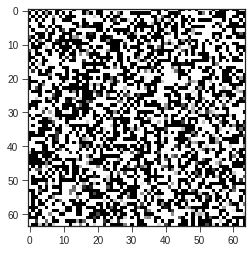

5 / 13


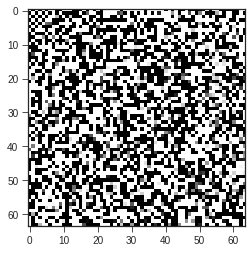

6 / 13


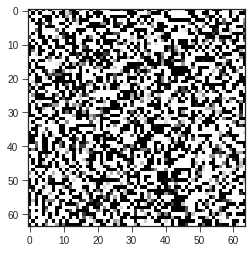

7 / 13


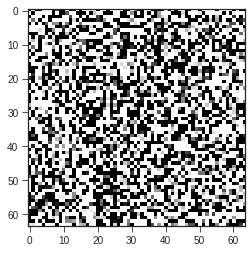

8 / 13


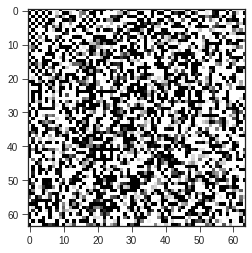

9 / 13


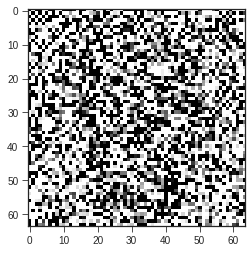

10 / 13


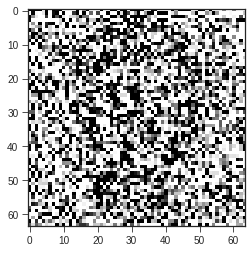

11 / 13


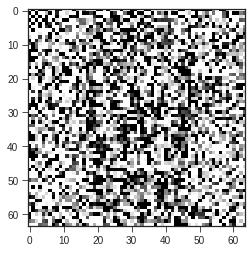

12 / 13


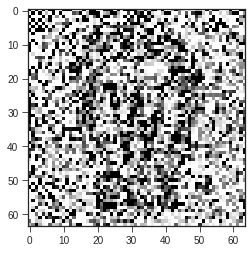

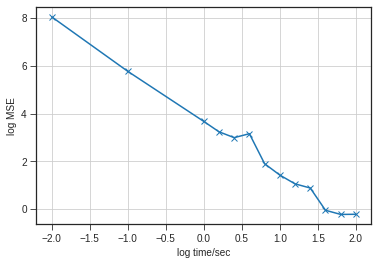

In [9]:
dir_name = "BS";

path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation/Before and After mask constant/save simulation result";
path += ('/' + mode);
path += "/ratio_value %.2e"%ratio_val;

os.chdir(path);

if os.path.exists(dir_name) == True:
    remove_dir(dir_name);

os.mkdir(dir_name);

os.chdir('/'.join([path, dir_name]));


light_level = [];

### Basis scan
measure = BS.prop["measure"];
photon_per_sec = BS.prop["n_photon"];
cycles = BS.prop["cycles"];
basis = BS.prop["phi"];

inv_basis = np.linalg.pinv(basis);
BS.Adding_prop("inv_phi", inv_basis);
Error = BS.prop["error"];

factor = cycles * (r*c);

for time_index in range(len(time)):
    pmt.YZ_process_bar((time_index+1)/len(time), theme = False);
    time_ep = time[time_index];

    n_ph_tot = time_ep * photon_per_sec;    
    light_level += [n_ph_tot / factor];
    measure[:,:,time_index] = pmt.PMT_measure_simu(light_level[-1], cycles,
                                                   Poisson = Pnoise, Gaussian = Gnoise,
                                                   upload_DMD_basis = basis);

#RS.prop["measure"] = measure;
################################################################################
#measure = RS.prop["measure"];


for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_direct_inverse_reconstruction(r, c, inv_basis, measure[:,:,time_index], CS = False);
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);

    recons_clipped = pmt.img_reconstructed;
    
    this_error = (np.mean((recons_clipped - pmt.img)**2));    
    
    Error[time_index] = this_error;

    condition = "%s. mode: %s_time: %.2e light_level: %.2e"%(time_index,mode, time[time_index], light_level[time_index])
    mpimg.imsave( condition +'.png', pmt.img_reconstructed, cmap = 'gray')
    
plt.figure();
plt.plot(np.log10(time), np.log(Error), marker = 'x');
plt.xlabel("log time/sec");
plt.ylabel("log MSE");
plt.grid();
plt.savefig("Error.jpg");
plt.show();

|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!0 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 7.916e+05} |··················································| 0.0%
{cost = 6.152e+04} |>>>>>>>>>>········································| 20.0%
{cost = 2.869e+04} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.057e+04} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.378e+04} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.111e+04} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

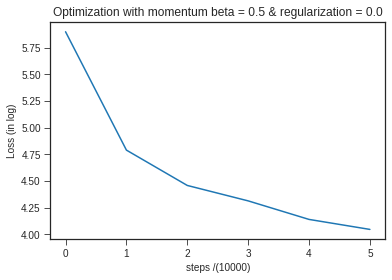

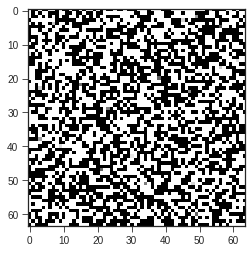

1 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 2.105e+05} |··················································| 0.0%
{cost = 6.100e+03} |>>>>>>>>>>········································| 20.0%
{cost = 3.094e+03} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.801e+03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.324e+03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.109e+03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

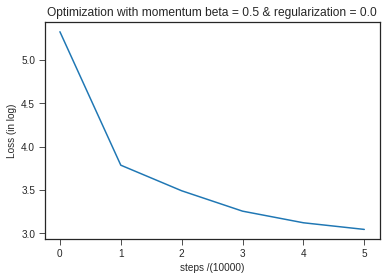

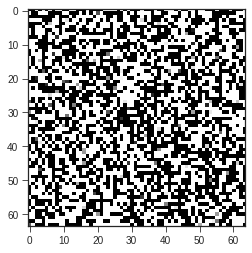

2 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.524e+05} |··················································| 0.0%
{cost = 6.908e+02} |>>>>>>>>>>········································| 20.0%
{cost = 3.266e+02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.077e+02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.745e+02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.284e+02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

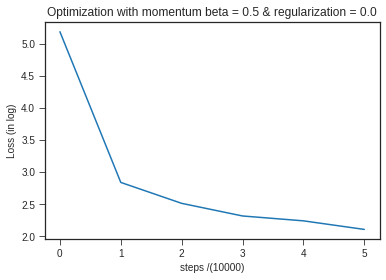

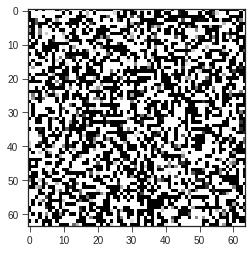

3 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.504e+05} |··················································| 0.0%
{cost = 4.141e+02} |>>>>>>>>>>········································| 20.0%
{cost = 1.837e+02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.219e+02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 8.854e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 6.958e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

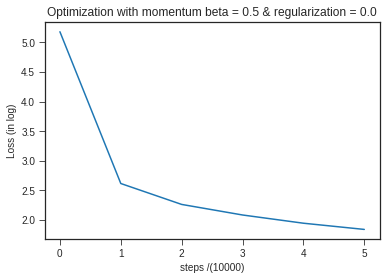

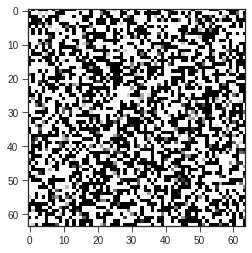

4 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.494e+05} |··················································| 0.0%
{cost = 2.795e+02} |>>>>>>>>>>········································| 20.0%
{cost = 1.246e+02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 9.792e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 6.016e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 4.849e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

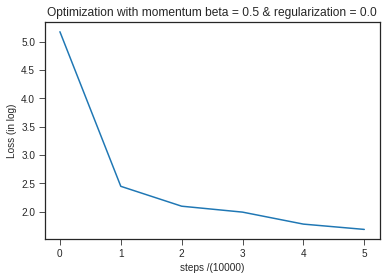

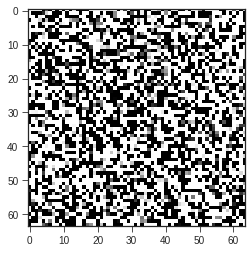

5 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.476e+05} |··················································| 0.0%
{cost = 1.911e+02} |>>>>>>>>>>········································| 20.0%
{cost = 9.621e+01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 6.391e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 4.879e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 6.013e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

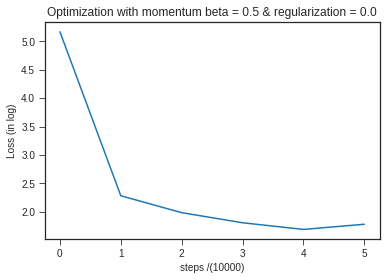

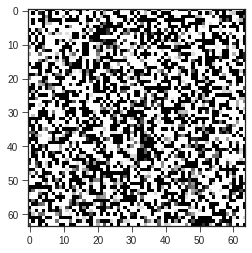

6 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.476e+05} |··················································| 0.0%
{cost = 1.083e+02} |>>>>>>>>>>········································| 20.0%
{cost = 5.934e+01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.456e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.739e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.355e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

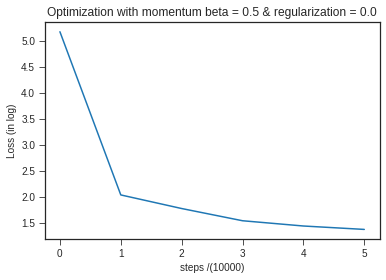

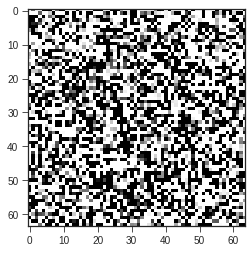

7 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.468e+05} |··················································| 0.0%
{cost = 6.759e+01} |>>>>>>>>>>········································| 20.0%
{cost = 2.922e+01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.907e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.439e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.119e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

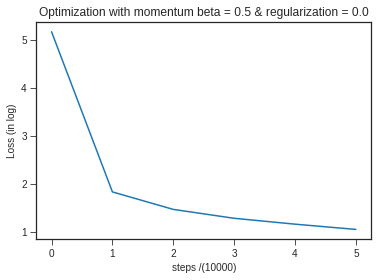

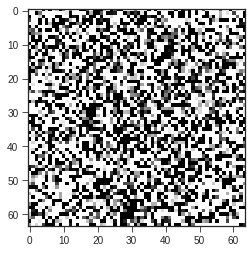

8 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.465e+05} |··················································| 0.0%
{cost = 3.838e+01} |>>>>>>>>>>········································| 20.0%
{cost = 1.953e+01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.143e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 8.044e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 6.633e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

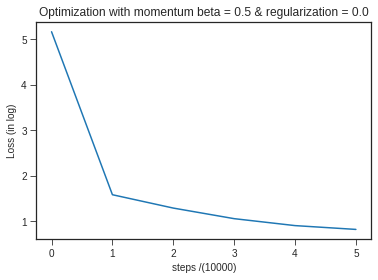

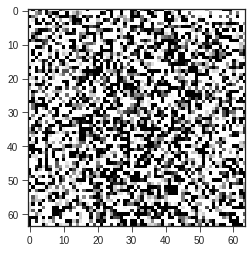

9 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.470e+05} |··················································| 0.0%
{cost = 3.010e+01} |>>>>>>>>>>········································| 20.0%
{cost = 1.351e+01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 8.694e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 8.213e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 5.624e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

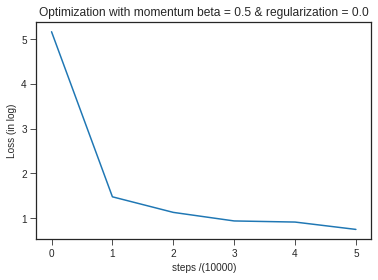

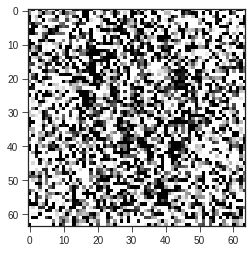

10 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.463e+05} |··················································| 0.0%
{cost = 1.689e+01} |>>>>>>>>>>········································| 20.0%
{cost = 7.345e+00} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 5.111e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 5.373e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 3.372e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

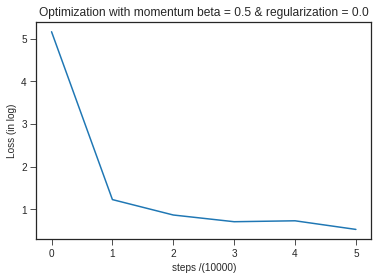

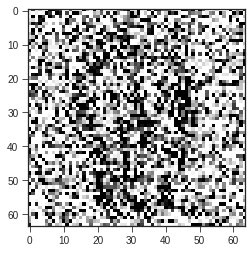

11 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.464e+05} |··················································| 0.0%
{cost = 1.119e+01} |>>>>>>>>>>········································| 20.0%
{cost = 4.535e+00} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 5.560e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.908e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.471e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

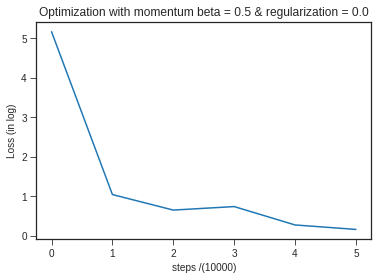

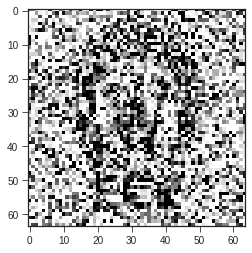

12 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.463e+05} |··················································| 0.0%
{cost = 6.553e+00} |>>>>>>>>>>········································| 20.0%
{cost = 2.982e+00} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.949e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.451e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.135e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

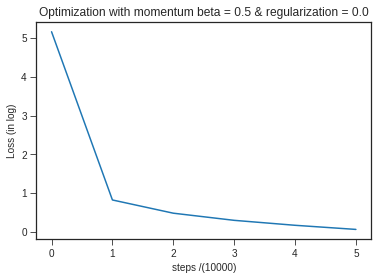

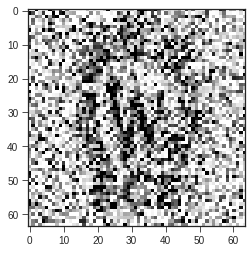

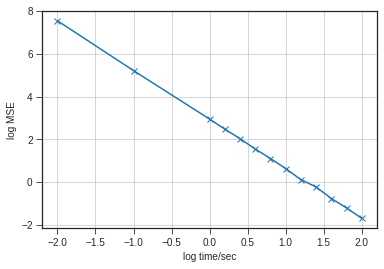

In [10]:
dir_name = "BS_CS";

path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation/Before and After mask constant/save simulation result";
path += ('/' + mode);
path += "/ratio_value %.2e"%ratio_val;

os.chdir(path);

if os.path.exists(dir_name) == True:
    remove_dir(dir_name);

os.mkdir(dir_name);

os.chdir('/'.join([path, dir_name]));


light_level = [];

### BS_CS
Obj = BS_CS;
measure = Obj.prop["measure"];
photon_per_sec = Obj.prop["n_photon"];
cycles = Obj.prop["cycles"];
basis = Obj.prop["phi"];

Error = Obj.prop["error"];

#factor = cycles * (r*c);
factor = cycles * (r*c);

for time_index in range(len(time)):
    pmt.YZ_process_bar((time_index+1)/len(time), theme = False);
    time_ep = time[time_index];

    n_ph_tot = time_ep * photon_per_sec;    
    light_level += [n_ph_tot / factor];
    measure[:,:,time_index] = pmt.PMT_measure_simu(light_level[-1], cycles,
                                                   Poisson = Pnoise, Gaussian = Gnoise,
                                                   upload_DMD_basis = basis);

###############################################################################
for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_reconstruct(r,c,measure[:,:,time_index], upload_DMD_basis = basis,
                        user_evaluation = False, learning_rate = 2e-3,
                        regularization = 0e-3, plot_step= 10000, max_epoch = 50000); ## No regularization

    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);

    recons_clipped = pmt.img_reconstructed;
    
    this_error = (np.mean((recons_clipped - pmt.img)**2));    
    Error[time_index] = this_error;

    condition = "%s. mode: %s_time: %.2e light_level: %.2e"%(time_index,mode, time[time_index], light_level[time_index])
    mpimg.imsave( condition +'.png', pmt.img_reconstructed, cmap = 'gray')
    
plt.figure();
plt.plot(np.log10(time), np.log(Error), marker = 'x');
plt.xlabel("log time/sec");
plt.ylabel("log MSE");
plt.grid();
plt.savefig("Error.jpg");
plt.show();

|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!0 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 3.362e+05} |··················································| 0.0%
{cost = 3.292e+01} |>>>>>>>>>>········································| 20.0%
{cost = 1.201e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.247e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.053e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.187e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

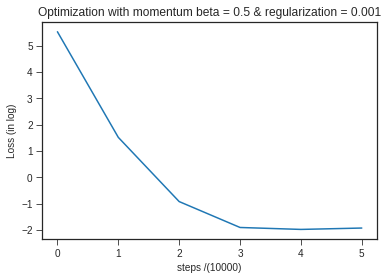

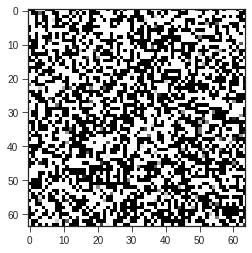

1 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.692e+05} |··················································| 0.0%
{cost = 2.687e+00} |>>>>>>>>>>········································| 20.0%
{cost = 2.526e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.070e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 9.997e-03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.019e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

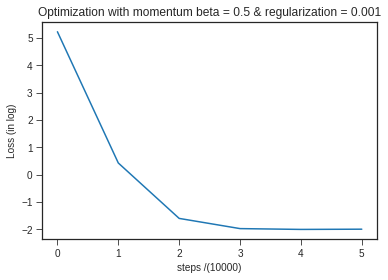

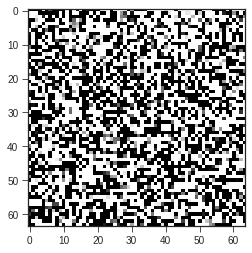

2 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.531e+05} |··················································| 0.0%
{cost = 3.252e-01} |>>>>>>>>>>········································| 20.0%
{cost = 1.331e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.054e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.055e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.079e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

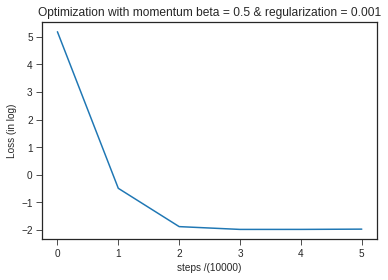

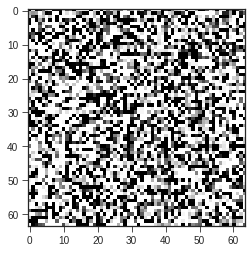

3 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.523e+05} |··················································| 0.0%
{cost = 2.370e-01} |>>>>>>>>>>········································| 20.0%
{cost = 1.262e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.046e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.117e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.038e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

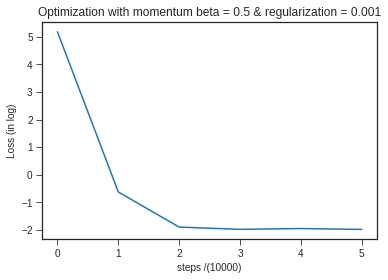

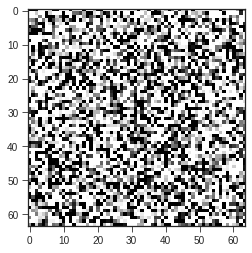

4 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.508e+05} |··················································| 0.0%
{cost = 2.144e-01} |>>>>>>>>>>········································| 20.0%
{cost = 1.218e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.032e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.036e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.153e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

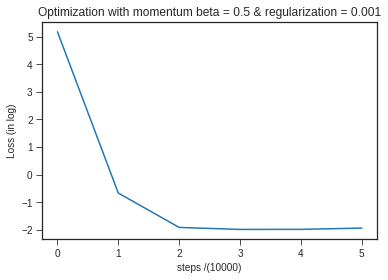

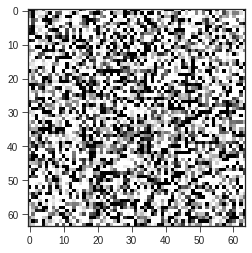

5 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.509e+05} |··················································| 0.0%
{cost = 1.111e-01} |>>>>>>>>>>········································| 20.0%
{cost = 1.178e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.090e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.027e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.084e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

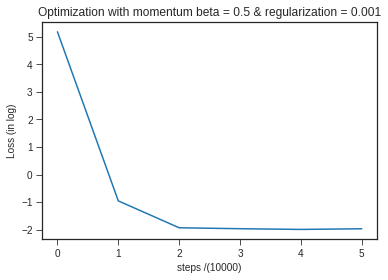

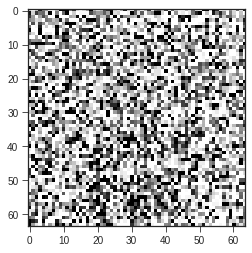

6 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.506e+05} |··················································| 0.0%
{cost = 1.093e-01} |>>>>>>>>>>········································| 20.0%
{cost = 1.210e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.073e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.011e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.056e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

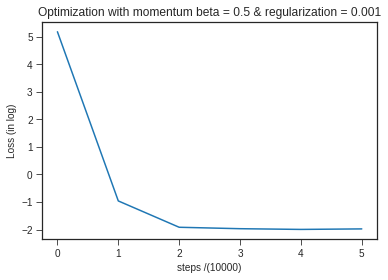

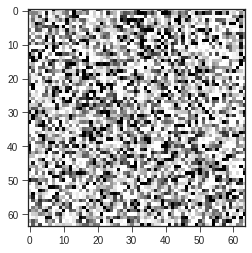

7 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.512e+05} |··················································| 0.0%
{cost = 6.487e-02} |>>>>>>>>>>········································| 20.0%
{cost = 1.174e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.051e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.006e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.091e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

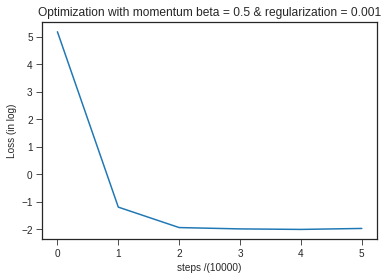

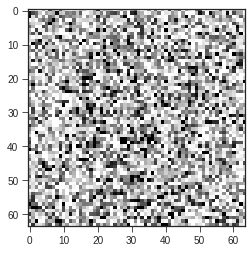

8 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.513e+05} |··················································| 0.0%
{cost = 5.018e-02} |>>>>>>>>>>········································| 20.0%
{cost = 1.090e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.138e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.067e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.032e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

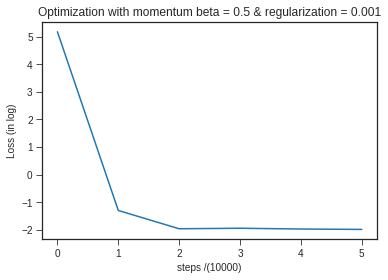

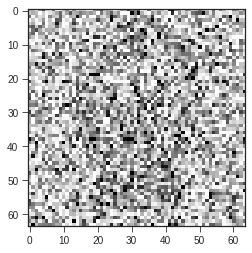

9 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.509e+05} |··················································| 0.0%
{cost = 3.103e-02} |>>>>>>>>>>········································| 20.0%
{cost = 1.012e-02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 9.525e-03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 9.264e-03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 9.013e-03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

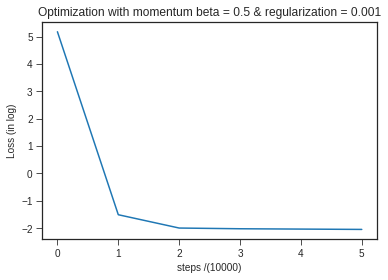

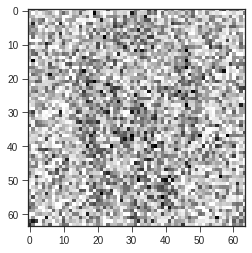

10 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.507e+05} |··················································| 0.0%
{cost = 2.799e-02} |>>>>>>>>>>········································| 20.0%
{cost = 9.783e-03} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 9.093e-03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 9.117e-03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 9.202e-03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

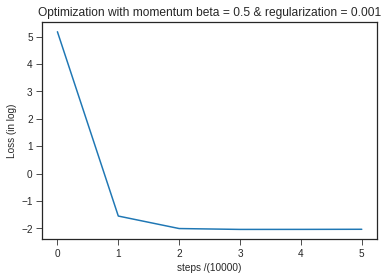

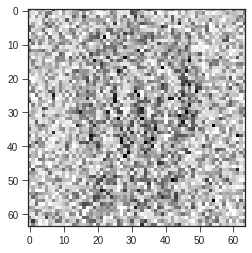

11 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.510e+05} |··················································| 0.0%
{cost = 2.313e-02} |>>>>>>>>>>········································| 20.0%
{cost = 8.869e-03} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 9.146e-03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 9.152e-03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 8.726e-03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

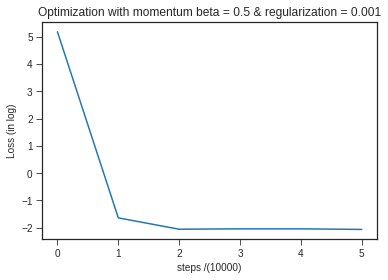

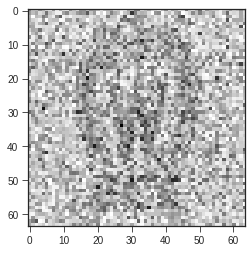

12 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.510e+05} |··················································| 0.0%
{cost = 1.806e-02} |>>>>>>>>>>········································| 20.0%
{cost = 8.374e-03} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 8.360e-03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 8.319e-03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 7.935e-03} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

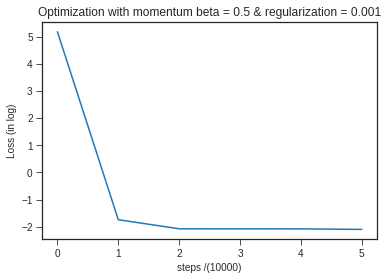

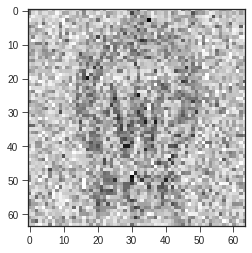

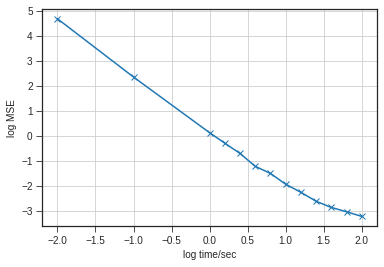

In [11]:
dir_name = "CS";

path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation/Before and After mask constant/save simulation result";
path += ('/' + mode);
path += "/ratio_value %.2e"%ratio_val;

os.chdir(path);

if os.path.exists(dir_name) == True:
    remove_dir(dir_name);

os.mkdir(dir_name);

os.chdir('/'.join([path, dir_name]));


light_level = [];

### CS
Obj = CS;
measure = Obj.prop["measure"];
photon_per_sec = Obj.prop["n_photon"];
cycles = Obj.prop["cycles"];
basis = Obj.prop["phi"];

Error = Obj.prop["error"];

factor = cycles * (r*c);

for time_index in range(len(time)):
    pmt.YZ_process_bar((time_index+1)/len(time), theme = False);
    time_ep = time[time_index];

    n_ph_tot = time_ep * photon_per_sec;    
    light_level += [n_ph_tot / factor];
    measure[:,:,time_index] = pmt.PMT_measure_simu(light_level[-1], cycles,
                                                   Poisson = Pnoise, Gaussian = Gnoise,
                                                   upload_DMD_basis = basis);

###############################################################################
for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_reconstruct(r,c,measure[:,:,time_index], upload_DMD_basis = basis,
                        user_evaluation = False, learning_rate = 2e-3,
                        regularization = 1e-3, plot_step= 10000, max_epoch = 50000);

    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);

    recons_clipped = pmt.img_reconstructed;
    
    this_error = (np.mean((recons_clipped - pmt.img)**2));    
    Error[time_index] = this_error;

    condition = "%s. mode: %s_time: %.2e light_level: %.2e"%(time_index,mode, time[time_index], light_level[time_index])
    mpimg.imsave( condition +'.png', pmt.img_reconstructed, cmap = 'gray')
    
plt.figure();
plt.plot(np.log10(time), np.log(Error), marker = 'x');
plt.xlabel("log time/sec");
plt.ylabel("log MSE");
plt.grid();
plt.savefig("Error.jpg");
plt.show();

|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!0 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 3.253e+05} |··················································| 0.0%
{cost = 1.979e+03} |>>>>>>>>>>········································| 20.0%
{cost = 8.286e+02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 4.530e+02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.765e+02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.491e+02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

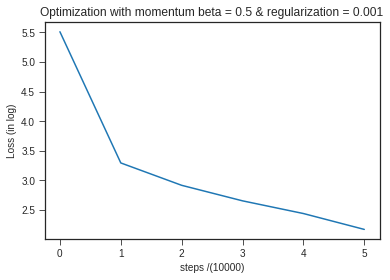

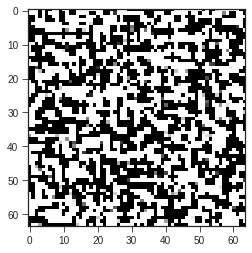

1 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.716e+05} |··················································| 0.0%
{cost = 2.485e+02} |>>>>>>>>>>········································| 20.0%
{cost = 1.206e+02} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 7.685e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.119e+02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 2.698e+01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

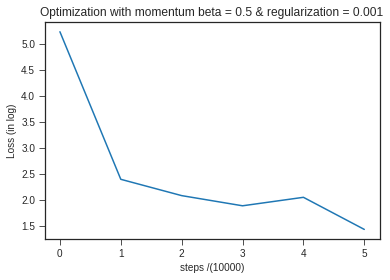

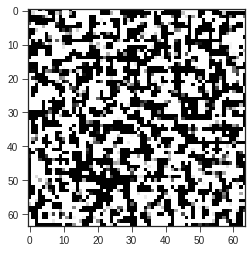

2 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.571e+05} |··················································| 0.0%
{cost = 2.034e+01} |>>>>>>>>>>········································| 20.0%
{cost = 9.482e+00} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 5.900e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 4.515e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 3.648e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

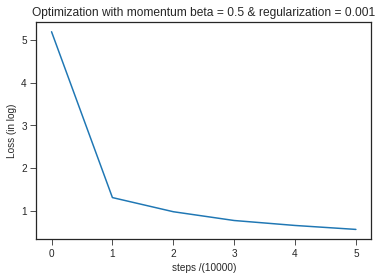

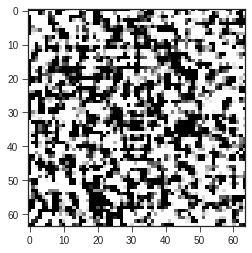

3 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.548e+05} |··················································| 0.0%
{cost = 1.937e+01} |>>>>>>>>>>········································| 20.0%
{cost = 8.403e+00} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 4.721e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 4.007e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.728e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

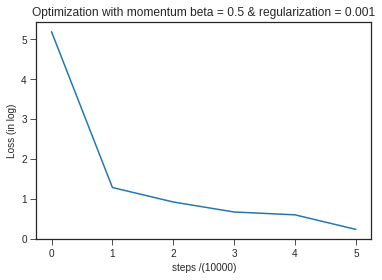

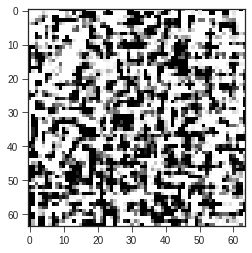

4 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.551e+05} |··················································| 0.0%
{cost = 1.070e+01} |>>>>>>>>>>········································| 20.0%
{cost = 4.141e+00} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.914e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 9.642e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 5.843e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

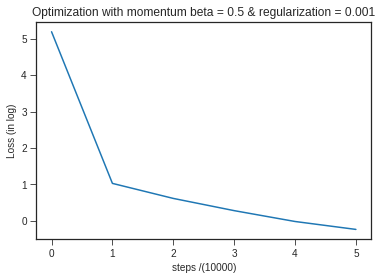

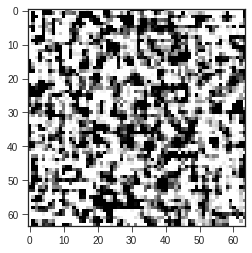

5 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.557e+05} |··················································| 0.0%
{cost = 3.670e+00} |>>>>>>>>>>········································| 20.0%
{cost = 9.807e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 4.448e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.480e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.726e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

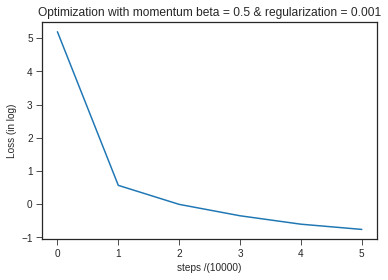

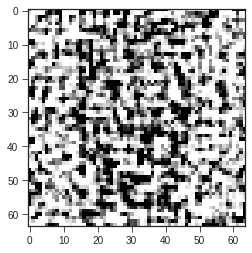

6 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.537e+05} |··················································| 0.0%
{cost = 6.331e+00} |>>>>>>>>>>········································| 20.0%
{cost = 3.221e+00} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.725e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.032e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.289e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

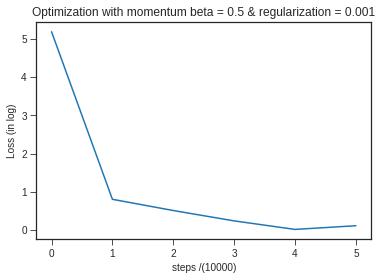

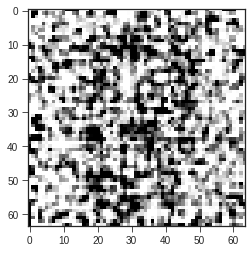

7 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.539e+05} |··················································| 0.0%
{cost = 6.179e+00} |>>>>>>>>>>········································| 20.0%
{cost = 2.018e+00} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.255e+00} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 7.397e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 6.024e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

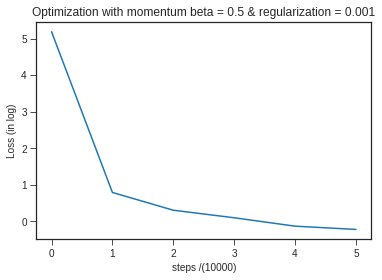

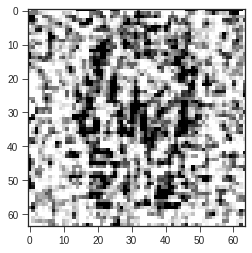

8 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.543e+05} |··················································| 0.0%
{cost = 2.123e+00} |>>>>>>>>>>········································| 20.0%
{cost = 9.662e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 4.926e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.601e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.679e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

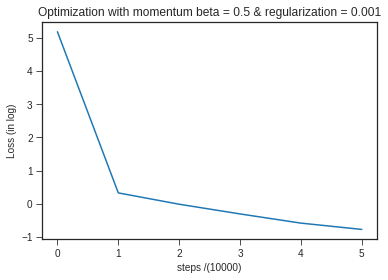

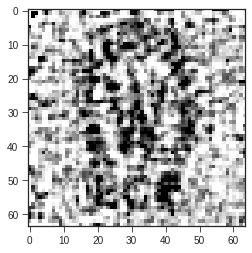

9 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.543e+05} |··················································| 0.0%
{cost = 1.609e+00} |>>>>>>>>>>········································| 20.0%
{cost = 7.123e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.732e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 2.602e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 1.775e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

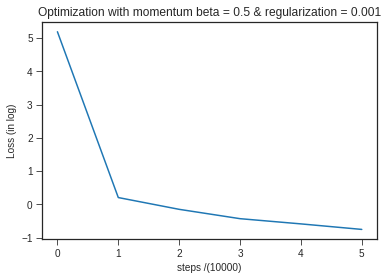

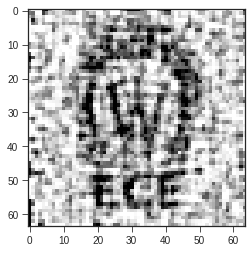

10 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.543e+05} |··················································| 0.0%
{cost = 7.921e-01} |>>>>>>>>>>········································| 20.0%
{cost = 3.766e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 2.220e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 1.823e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 9.955e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

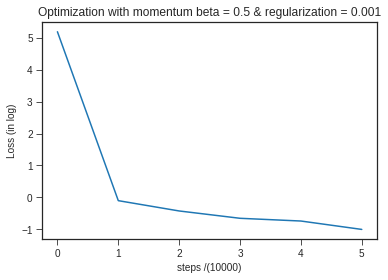

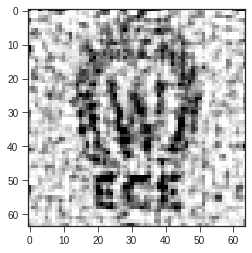

11 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.541e+05} |··················································| 0.0%
{cost = 6.328e-01} |>>>>>>>>>>········································| 20.0%
{cost = 4.050e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 1.587e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 9.977e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 7.631e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

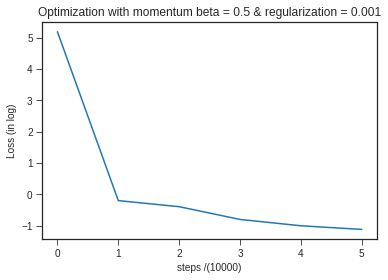

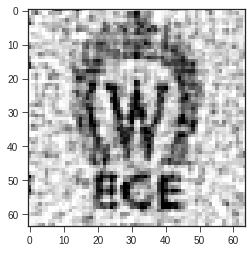

12 / 13
Mini-batch (size 10) Gradient Ascent!

{cost = 1.543e+05} |··················································| 0.0%
{cost = 5.877e-01} |>>>>>>>>>>········································| 20.0%
{cost = 3.049e-01} |>>>>>>>>>>>>>>>>>>>>······························| 40.0%
{cost = 3.973e-01} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>····················| 60.0%
{cost = 9.967e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>··········| 80.0%
{cost = 7.537e-02} |>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!

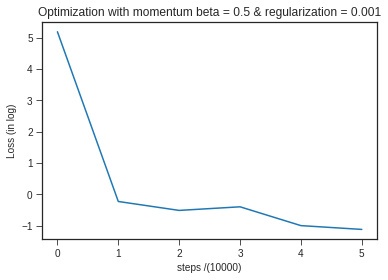

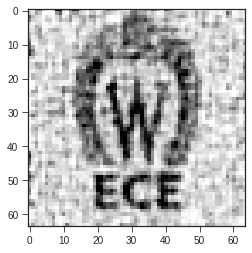

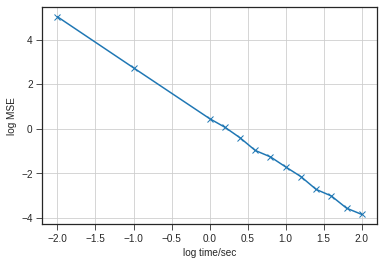

In [12]:
dir_name = "HR";

path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation/Before and After mask constant/save simulation result";
path += ('/' + mode);
path += "/ratio_value %.2e"%ratio_val;

os.chdir(path);

if os.path.exists(dir_name) == True:
    remove_dir(dir_name);

os.mkdir(dir_name);

os.chdir('/'.join([path, dir_name]));


light_level = [];

### HR
Obj = HR;
measure = Obj.prop["measure"];
photon_per_sec = Obj.prop["n_photon"];
cycles = Obj.prop["cycles"];
basis = Obj.prop["phi"];

Error = Obj.prop["error"]
factor = cycles * (r*c);

for time_index in range(len(time)):
    pmt.YZ_process_bar((time_index+1)/len(time), theme = False);
    time_ep = time[time_index];

    n_ph_tot = time_ep * photon_per_sec;    
    light_level += [n_ph_tot / factor];
    measure[:,:,time_index] = pmt.PMT_measure_simu(light_level[-1], cycles,
                                                   Poisson = Pnoise, Gaussian = Gnoise,
                                                   upload_DMD_basis = basis);

###############################################################################
for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_reconstruct(r,c,measure[:,:,time_index], upload_DMD_basis = basis,
                        user_evaluation = False, learning_rate = 2e-3,
                        regularization = 1e-3, plot_step= 10000, max_epoch = 50000);

    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);

    recons_clipped = pmt.img_reconstructed;
    
    this_error = (np.mean((recons_clipped - pmt.img)**2));    
    Error[time_index] = this_error;
    
    condition = "%s. mode: %s_time: %.2e light_level: %.2e"%(time_index,mode, time[time_index], light_level[time_index])
    mpimg.imsave( condition +'.png', pmt.img_reconstructed, cmap = 'gray')
    
plt.figure();
plt.plot(np.log10(time), np.log(Error), marker = 'x');
plt.xlabel("log time/sec");
plt.ylabel("log MSE");
plt.grid();
plt.savefig("Error.jpg");
plt.show();

|>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>| 100.0% (^_^)/ Done!0 / 13


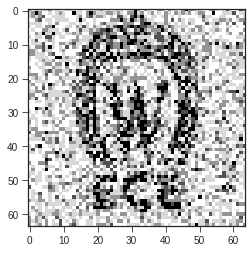

1 / 13


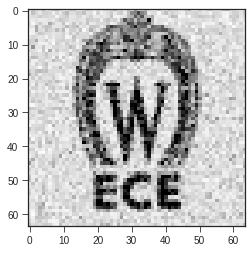

2 / 13


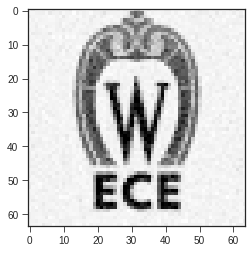

3 / 13


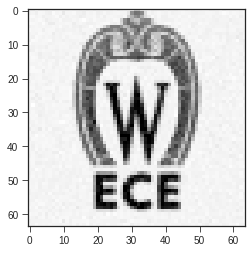

4 / 13


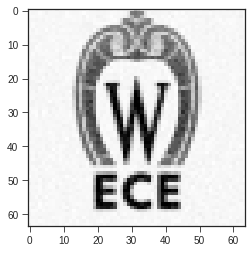

5 / 13


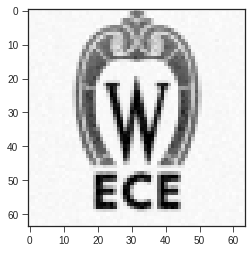

6 / 13


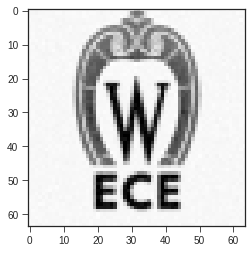

7 / 13


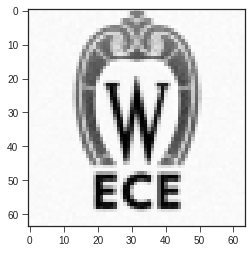

8 / 13


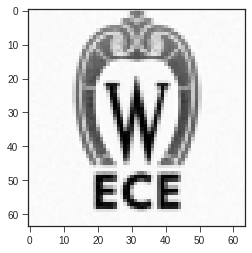

9 / 13


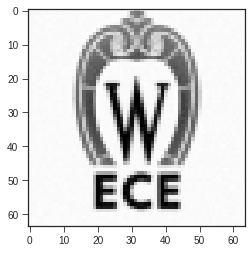

10 / 13


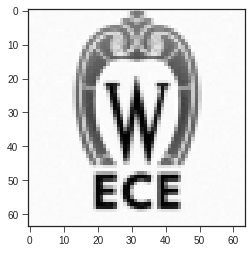

11 / 13


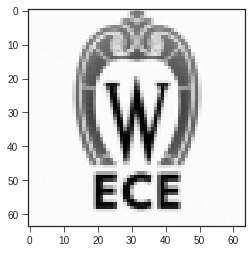

12 / 13


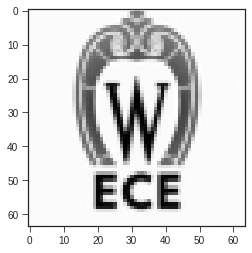

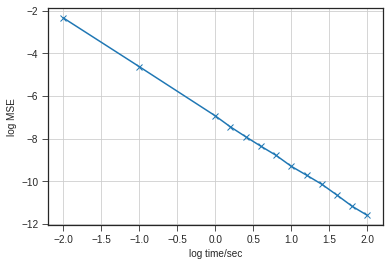

In [13]:
dir_name = "Voxtel";

path = "/content/drive/Shared drives/Computational Optics Group/Yizhou_Lu_FLIM/DMD simulation/Before and After mask constant/save simulation result";
path += ('/' + mode);
path += "/ratio_value %.2e"%ratio_val;

os.chdir(path);

if os.path.exists(dir_name) == True:
    remove_dir(dir_name);

os.mkdir(dir_name);

os.chdir('/'.join([path, dir_name]));


light_level = [];

### Voxtel
Obj = Voxtel;
measure = Obj.prop["measure"];
photon_per_sec = Obj.prop["n_photon"];
cycles = Obj.prop["cycles"];
basis = Obj.prop["phi"];
inv_basis = basis;

Error = Obj.prop["error"];

factor = (r*c); ## every pixel: n_photons / (n_pixels)

for time_index in range(len(time)):
    pmt.YZ_process_bar((time_index+1)/len(time), theme = False);
    time_ep = time[time_index];

    n_ph_tot = time_ep * photon_per_sec;    
    light_level += [n_ph_tot / factor];
    measure[:,:,time_index] = pmt.PMT_measure_simu(light_level[-1], cycles,
                                                   Poisson = Pnoise, Gaussian = Gnoise,
                                                   upload_DMD_basis = basis);

for time_index in range(len(time)):
    print(time_index, '/', len(time));
    pmt.PMT_direct_inverse_reconstruction(r, c, inv_basis, measure[:,:,time_index], CS = False);
    recons_clipped = np.clip(pmt.img_reconstructed, a_min = 0,a_max = 1);

    recons_clipped = pmt.img_reconstructed;

    this_error = (np.mean((recons_clipped - pmt.img)**2));    
    
    Error[time_index] = this_error;

    condition = "%s. mode: %s_time: %.2e light_level: %.2e"%(time_index,mode, time[time_index], light_level[time_index])
    mpimg.imsave( condition +'.png', pmt.img_reconstructed, cmap = 'gray')
    
plt.figure();
plt.plot(np.log10(time), np.log(Error), marker = 'x');
plt.xlabel("log time/sec");
plt.ylabel("log MSE");
plt.grid();
plt.savefig("Error.jpg");
plt.show();

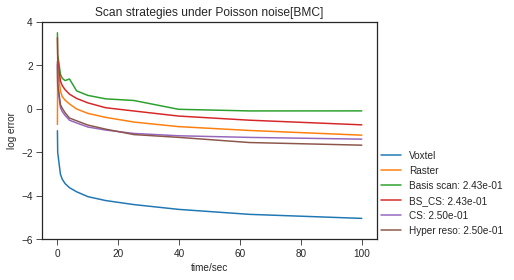

In [14]:
plt.figure();
plt.plot(time, np.log10(Voxtel.prop["error"]), label = "Voxtel")
plt.plot(time, np.log10(RS.prop["error"]), label = "Raster");
plt.plot(time, np.log10(BS.prop["error"]), label = "Basis scan: %.2e"%(np.mean(BS.prop['phi'])));
plt.plot(time, np.log10(BS_CS.prop["error"]), label = "BS_CS: %.2e"%(np.mean(BS_CS.prop['phi'])));
plt.plot(time, np.log10(CS.prop["error"]), label = "CS: %.2e"%(np.mean(CS.prop['phi'])));
plt.plot(time, np.log10(HR.prop["error"]), label = "Hyper reso: %.2e"%(np.mean(HR.prop['phi'])));
#plt.plot(time, np.log10(Error_hr_Haar), label = "Hyper reso + Haar basis");

plt.xlabel("time/sec");
plt.ylabel("log error");
plt.ylim(-6,4)
plt.title("Scan strategies under Poisson noise[BMC]")
plt.legend(loc=[1,0]);
plt.show();

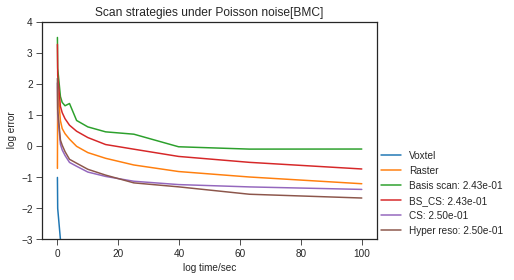

In [15]:
plt.figure();

plt.plot(time, np.log10(Voxtel.prop["error"]), label = "Voxtel")
plt.plot(time, np.log10(RS.prop["error"]), label = "Raster");

plt.plot((time), np.log10(BS.prop["error"]), label = "Basis scan: %.2e"%(np.mean(BS.prop['phi'])));
plt.plot((time), np.log10(BS_CS.prop["error"]), label = "BS_CS: %.2e"%(np.mean(BS_CS.prop['phi'])));

plt.plot((time), np.log10(CS.prop["error"]), label = "CS: %.2e"%(np.mean(CS.prop['phi'])));
plt.plot((time), np.log10(HR.prop["error"]), label = "Hyper reso: %.2e"%(np.mean(HR.prop['phi'])));
#plt.plot(time, np.log10(Error_hr_Haar), label = "Hyper reso + Haar basis");

plt.xlabel("log time/sec");
plt.ylabel(" log error");
plt.ylim(-3,4.)
plt.title("Scan strategies under Poisson noise[BMC]")
plt.legend(loc=[1,0]);
plt.show();

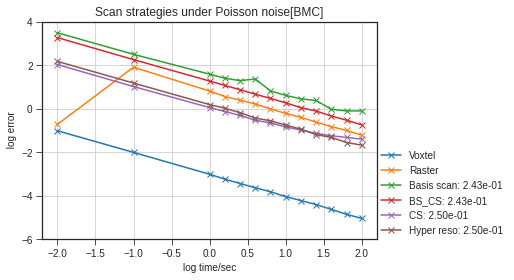

In [16]:
os.chdir(path);

plt.figure();
plt.plot(np.log10(time), np.log10(Voxtel.prop["error"]), marker = 'x',label = "Voxtel")
plt.plot(np.log10(time), np.log10(RS.prop["error"]), marker = 'x',label = "Raster");

plt.plot(np.log10(time), np.log10(BS.prop["error"]), marker = 'x',label = "Basis scan: %.2e"%(np.mean(BS.prop['phi'])));
plt.plot(np.log10(time), np.log10(BS_CS.prop["error"]), marker = 'x',label = "BS_CS: %.2e"%(np.mean(BS_CS.prop['phi'])));

plt.plot(np.log10(time), np.log10(CS.prop["error"]), marker = 'x',label = "CS: %.2e"%(np.mean(CS.prop['phi'])));
plt.plot(np.log10(time), np.log10(HR.prop["error"]), marker = 'x',label = "Hyper reso: %.2e"%(np.mean(HR.prop['phi'])));
#plt.plot(time, np.log10(Error_hr_Haar), label = "Hyper reso + Haar basis");

plt.xlabel("log time/sec");
plt.ylabel(" log error");
plt.ylim(-6,4.)
plt.title("Scan strategies under Poisson noise[BMC]")
plt.legend(loc=[1,0]);
plt.grid();

plt.savefig("MSE.png")
plt.show();

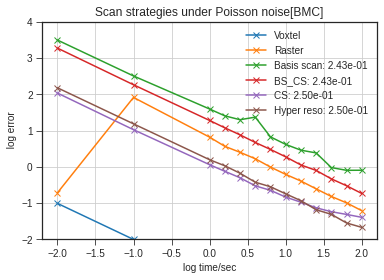

In [17]:
plt.figure();
plt.plot(np.log10(time), np.log10(Voxtel.prop["error"]), marker = 'x', label = "Voxtel")
plt.plot(np.log10(time), np.log10(RS.prop["error"]), marker = 'x',label = "Raster");

plt.plot(np.log10(time), np.log10(BS.prop["error"]), marker = 'x',label = "Basis scan: %.2e"%(np.mean(BS.prop['phi'])));
plt.plot(np.log10(time), np.log10(BS_CS.prop["error"]), marker = 'x',label = "BS_CS: %.2e"%(np.mean(BS_CS.prop['phi'])));

plt.plot(np.log10(time), np.log10(CS.prop["error"]), marker = 'x',label = "CS: %.2e"%(np.mean(CS.prop['phi'])));
plt.plot(np.log10(time), np.log10(HR.prop["error"]), marker = 'x',label = "Hyper reso: %.2e"%(np.mean(HR.prop['phi'])));
#plt.plot(time, np.log10(Error_hr_Haar), label = "Hyper reso + Haar basis");

plt.xlabel("log time/sec");
plt.ylabel(" log error");
plt.ylim(-2,4.)
plt.title("Scan strategies under Poisson noise[BMC]")
plt.legend(loc=False);
plt.grid();

plt.savefig("MSE_zoomed_in.png")
plt.show();

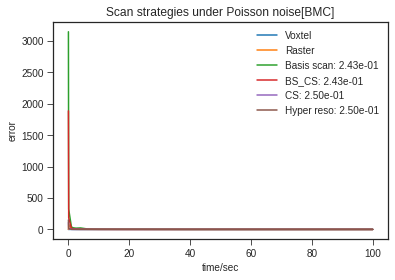

In [18]:
plt.figure();
plt.plot((time), (Voxtel.prop["error"]), label = "Voxtel")
plt.plot((time), (RS.prop["error"]), label = "Raster");
plt.plot((time), (BS.prop["error"]), label = "Basis scan: %.2e"%(np.mean(BS.prop['phi'])));
plt.plot((time), (BS_CS.prop["error"]), label = "BS_CS: %.2e"%(np.mean(BS_CS.prop['phi'])));
plt.plot((time), (CS.prop["error"]), label = "CS: %.2e"%(np.mean(CS.prop['phi'])));
plt.plot((time), (HR.prop["error"]), label = "Hyper reso: %.2e"%(np.mean(HR.prop['phi'])));
#plt.plot(time, np.log10(Error_hr_Haar), label = "Hyper reso + Haar basis");

plt.xlabel("time/sec");
plt.ylabel("error");
#plt.ylim(-6,4.)
plt.title("Scan strategies under Poisson noise[BMC]")
plt.legend(loc=False);
plt.show();